In [1]:
# Notebook for Analysis of LDH Assay.
# Import dataframe analysis and plotting libraries.

import re

import arcadia_pycolor as apc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import f_oneway
from sklearn.metrics import r2_score
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
# Set working directory for this experiment.
# Working directory should be where raw data are saved.
# Processed data will also save here.
import os

directory = "/Users/justin/Documents/itch_peptides/experimental_data/20250115_SLIGRL_hex_LDH/"

os.chdir(directory)
print(os.getcwd())

/Users/justin/Documents/itch_peptides/experimental_data/20250115_SLIGRL_hex_LDH


In [3]:
# Parameterization

data_filename = "20250115_SLIGRL_ldh.csv"  # enter raw data file name here
manifest_filename = "20250115_ldh_manifest.csv"  # enter sample manifest file name here

background = "0"  # enter the data label for the background samples
standard_columns = [
    "250",
    "200",
    "150",
    "100",
    "50",
]  # enter the standard column values as a list of strings

V = 0.05  # Total sample volume in mL, should be 0.05 unless the protocol is altered
experiment_id = "20250115 SLIGRL RBL-2H3"  # For final data plot label

In [4]:
data_path = os.path.join(directory, data_filename)

if os.path.exists(data_path):
    data = pd.read_csv(data_path)
    print(f"File '{data_filename}' loaded successfully.")
else:
    print(f"Error: File '{data_filename}' not found in the directory '{directory}'.")
    print(
        """
        Please check the file path, file name,
        and ensure the file is present in the working directory.
        """
    )

File '20250115_SLIGRL_ldh.csv' loaded successfully.


In [5]:
# Metadata are found in rows where both column A and column B have non-empty values,
# so metadata are extracted by identifying rows with non-empty values in these columns.

metadata = data.dropna(subset=["User", "Public"])
metadata = metadata.iloc[:, :2]
metadata.to_csv(data_filename[:-4] + "_metadata.csv", index=False)
metadata

,User,Public
0,Protocol name,New ABS Protocol
1,Time of export,01/15/2025 21:44:34
2,Time of last change,01/15/2025 21:07:43
3,Time of last use (end time),01/15/2025 21:38:16
4,Software version,1.2.0.0
5,Instrument name,iD3-2585
6,Serial number,2585
10,Experiment name,Experiment 1
13,Plate name,Plate 1
15,Microplate name,Standard clrbtm


In [6]:
# Samples are laid out in columns defined by the well position in a 96-well plate,
# each row corresponds to a time-point.
# Look for a row where columns contain values A1, A2, ..., H11, H12.

pattern = r"^[A-H][1-9]$|^[A-H]1[0-2]$"


def find_header_index(data, pattern):
    """
    Find the row index of the defined pattern of well labels that
    identifies the location of the sample data.

    Args:
        data: The raw dataframe exported from the plate reader and imported into pandas
        pattern: The regular expression that defines the well headers (typically A1 - H12)

    Returns:
        int: The row index of the well headers
    """
    for idx, row in data.iterrows():
        non_nan_values = row[2:].dropna()
        if (
            len(non_nan_values) > 0
            and sum(bool(re.match(pattern, str(val))) for val in non_nan_values)
            >= len(non_nan_values) / 2
        ):
            return idx
    raise ValueError("No valid header row found. Please check the data structure.")


# Header row index should be found by find_header_index.
# The header_index printout can be used to verify that this is done correctly.
# Check that the raw csv file is appropriately structured if issues are encountered.
header_index = find_header_index(data, pattern)
print(header_index)

sample_data = data.iloc[header_index + 1 :, 2:].dropna(how="all")
sample_data = sample_data.reset_index(drop=True)

# The first column is 'Cycle (seconds)', defining it as the time column,
# and remaining columns are well positions (A1 - H12).
column_names = ["Cycle (seconds)"] + [
    col for col in data.iloc[header_index, 2:] if re.match(pattern, str(col))
]
sample_data.columns = column_names

sample_data.to_csv(data_filename[:-4] + "_sample_data.csv", index=False)
sample_data

50


,Cycle (seconds),A1,A2,A3,A4,A5,A6,A7,A8,A9,...,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
0,0,0.147,0.146,0.152,0.158,0.155,0.104,0.103,0.104,0.108,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,119.07,0.212,0.204,0.218,0.234,0.227,0.116,0.114,0.116,0.124,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,239.05,0.294,0.277,0.297,0.325,0.313,0.132,0.129,0.133,0.144,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,359.96,0.39,0.363,0.391,0.431,0.415,0.152,0.147,0.153,0.17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,479.88,0.492,0.457,0.493,0.546,0.524,0.175,0.168,0.176,0.198,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,600.05,0.598,0.555,0.6,0.664,0.638,0.201,0.191,0.201,0.229,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,719.98,0.706,0.656,0.709,0.784,0.753,0.228,0.215,0.228,0.262,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,839.9,0.813,0.757,0.817,0.902,0.868,0.256,0.241,0.257,0.297,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,959.8,0.918,0.856,0.924,1.019,0.982,0.286,0.268,0.287,0.334,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1079.97,1.02,0.954,1.03,1.133,1.092,0.316,0.296,0.317,0.37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Data must be restructured and labeled for plotting and analysis,
# so sample manifest is used to sort and label data.

manifest_path = os.path.join(directory, manifest_filename)

if os.path.exists(manifest_path):
    manifest = pd.read_csv(manifest_filename)
    print(f"File '{manifest_filename}' loaded successfully.")
else:
    print(f"Error: File '{manifest_filename}' not found in the directory '{directory}'.")
    print(
        """Please check the file path, file name,
        and ensure the file is present in the working directory.
        """
    )

manifest

File '20250115_ldh_manifest.csv' loaded successfully.


,Manifest,1,2,3,4,5,6,7,8,9,10,11,12
0,A,"SLIGRL 900 µM, 1x dilution","SLIGRL 300 µM, 1x dilution","SLIGRL 100 µM, 1x dilution","SLIGRL 33.3 µM, 1x dilution","SLIGRL 11.1 µM, 1x dilution","SLIGRL 900 µM, 5x dilution","SLIGRL 300 µM, 5x dilution","SLIGRL 100 µM, 5x dilution","SLIGRL 33.3 µM, 5x dilution","SLIGRL 11.1 µM, 5x dilution","48/80, 5x dilution","PBS, 1x dilution"
1,B,"SLIGRL 900 µM, 1x dilution","SLIGRL 300 µM, 1x dilution","SLIGRL 100 µM, 1x dilution","SLIGRL 33.3 µM, 1x dilution","SLIGRL 11.1 µM, 1x dilution","SLIGRL 900 µM, 5x dilution","SLIGRL 300 µM, 5x dilution","SLIGRL 100 µM, 5x dilution","SLIGRL 33.3 µM, 5x dilution","SLIGRL 11.1 µM, 5x dilution","48/80, 5x dilution","PBS, 1x dilution"
2,C,"SLIGRL 900 µM, 1x dilution","SLIGRL 300 µM, 1x dilution","SLIGRL 100 µM, 1x dilution","SLIGRL 33.3 µM, 1x dilution","SLIGRL 11.1 µM, 1x dilution","SLIGRL 900 µM, 5x dilution","SLIGRL 300 µM, 5x dilution","SLIGRL 100 µM, 5x dilution","SLIGRL 33.3 µM, 5x dilution","SLIGRL 11.1 µM, 5x dilution","48/80, 5x dilution","PBS, 1x dilution"
3,D,250,200,150,100,50,0,"LDH Positive Control, 1x dilution","LDH Positive Control, 1x dilution","LDH Positive Control, 1x dilution",NaN,NaN,NaN
4,E,250,200,150,100,50,0,"LDH Positive Control, 5x dilution","LDH Positive Control, 5x dilution","LDH Positive Control, 5x dilution",NaN,NaN,NaN
5,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# A dictionary relating each well position to the corresponding sample name
# will be used to label the raw data.
manifest_dict = {}

for _index, row in manifest.iterrows():
    row_label = row["Manifest"]
    for col_label, value in row.items():
        if col_label != "Manifest" and pd.notna(value):
            well_position = f"{row_label}{col_label}"
            manifest_dict[well_position] = value

# Retain only columns that exist in the manifest_dict keys or are 'Cycle (seconds)'
columns_to_keep = [
    col for col in sample_data.columns if col in manifest_dict or col == "Cycle (seconds)"
]
sample_data_labeled = sample_data[columns_to_keep]

# Rename columns based on the manifest_dict values
sample_data_labeled = sample_data_labeled.rename(columns=manifest_dict)

# Clean-up steps are included to make sure that elements in
# sample_data_labeled are of appropriate types.
# All cell values are floats or NaN, all column header values are strings.
sample_data_labeled = sample_data_labeled.replace("#SAT", np.nan)
sample_data_labeled.columns = sample_data_labeled.columns.map(
    lambda x: str(int(x)) if isinstance(x, float) and x.is_integer() else str(x)
)

sample_data_labeled.to_csv(data_filename[:-4] + "_sample_data_labeled.csv", index=False)
sample_data_labeled

,Cycle (seconds),"SLIGRL 900 µM, 1x dilution","SLIGRL 300 µM, 1x dilution","SLIGRL 100 µM, 1x dilution","SLIGRL 33.3 µM, 1x dilution","SLIGRL 11.1 µM, 1x dilution","SLIGRL 900 µM, 5x dilution","SLIGRL 300 µM, 5x dilution","SLIGRL 100 µM, 5x dilution","SLIGRL 33.3 µM, 5x dilution",...,"LDH Positive Control, 1x dilution",250,200,150,100,50,0,"LDH Positive Control, 5x dilution","LDH Positive Control, 5x dilution","LDH Positive Control, 5x dilution"
0,0,0.147,0.146,0.152,0.158,0.155,0.104,0.103,0.104,0.108,...,0.101,1.584,1.472,1.321,1.079,0.7,0.094,0.096,0.104,0.101
1,119.07,0.212,0.204,0.218,0.234,0.227,0.116,0.114,0.116,0.124,...,0.109,1.592,1.476,1.333,1.083,0.698,0.095,0.096,0.103,0.102
2,239.05,0.294,0.277,0.297,0.325,0.313,0.132,0.129,0.133,0.144,...,0.118,1.596,1.483,1.338,1.095,0.702,0.094,0.097,0.105,0.103
3,359.96,0.39,0.363,0.391,0.431,0.415,0.152,0.147,0.153,0.17,...,0.13,1.603,1.487,1.342,1.096,0.71,0.093,0.099,0.107,0.105
4,479.88,0.492,0.457,0.493,0.546,0.524,0.175,0.168,0.176,0.198,...,0.142,1.601,1.49,1.342,1.097,0.71,0.094,0.101,0.108,0.108
5,600.05,0.598,0.555,0.6,0.664,0.638,0.201,0.191,0.201,0.229,...,0.156,1.597,1.488,1.343,1.098,0.71,0.094,0.103,0.111,0.111
6,719.98,0.706,0.656,0.709,0.784,0.753,0.228,0.215,0.228,0.262,...,0.171,1.597,1.487,1.342,1.097,0.71,0.096,0.106,0.113,0.114
7,839.9,0.813,0.757,0.817,0.902,0.868,0.256,0.241,0.257,0.297,...,0.187,1.594,1.487,1.343,1.097,0.71,0.096,0.108,0.116,0.117
8,959.8,0.918,0.856,0.924,1.019,0.982,0.286,0.268,0.287,0.334,...,0.203,1.594,1.487,1.342,1.096,0.71,0.094,0.111,0.119,0.12
9,1079.97,1.02,0.954,1.03,1.133,1.092,0.316,0.296,0.317,0.37,...,0.22,1.59,1.484,1.342,1.096,0.71,0.094,0.114,0.121,0.124


In [9]:
# Background signal should be subtracted from all samples.
# Background signal is calculated separately at each time point
# to control for any time-dependent changes in the background signal.
# Check the blank_means printout to see whether the background signal
# changes significantly over time.


def generate_row_means(df):
    """
    Calculate the mean of each row in a dataframe.

    Args:
        df: A pandas dataframe.

    Returns:
        list[float]: A list of mean values of each row in the input dataframe.
    """
    df = df.apply(pd.to_numeric, errors="coerce")

    means = []

    for _, row in df.iterrows():
        row_mean = row.mean(skipna=True)
        means.append(float(row_mean))

    return means


filtered_data = sample_data_labeled[background]
filtered_data = filtered_data.apply(pd.to_numeric, errors="coerce")

blank_means = generate_row_means(filtered_data)
print(blank_means)

[0.0955, 0.095, 0.0945, 0.0935, 0.0945, 0.0945, 0.0955, 0.0955, 0.0945, 0.0945, 0.0955, 0.095, 0.096, 0.0955, 0.0955, 0.0955]


In [10]:
def subtract_row_means(data, means):
    """
    Subtracts each value in a list of background means
    from the corresponding time row in the DataFrame.

    Args:
        data: A pandas dataframe containing labeled raw data.
        means: A list of floats containing the mean background signal at each time point.

    Returns:
        pd.Dataframe: Labeled background-subtracted data, with background columns dropped.
    """
    data_numeric = data.apply(pd.to_numeric, errors="coerce")

    if len(data_numeric) != len(means):
        raise ValueError("Length of means list must match the number of rows in the DataFrame.")

    data_subtracted = data_numeric.apply(lambda row: row - means[row.name], axis=1)

    return data_subtracted


sample_data_labeled_nb = subtract_row_means(
    sample_data_labeled, blank_means
)  # Perform background subtraction
sample_data_labeled_nb = sample_data_labeled_nb.drop(columns=background)
sample_data_labeled_nb.to_csv(
    data_filename[:-4] + "_sample_data_labeled_nb.csv", index=False
)  # Save to a new CSV file
sample_data_labeled_nb

,Cycle (seconds),"SLIGRL 900 µM, 1x dilution","SLIGRL 300 µM, 1x dilution","SLIGRL 100 µM, 1x dilution","SLIGRL 33.3 µM, 1x dilution","SLIGRL 11.1 µM, 1x dilution","SLIGRL 900 µM, 5x dilution","SLIGRL 300 µM, 5x dilution","SLIGRL 100 µM, 5x dilution","SLIGRL 33.3 µM, 5x dilution",...,"LDH Positive Control, 1x dilution","LDH Positive Control, 1x dilution",250,200,150,100,50,"LDH Positive Control, 5x dilution","LDH Positive Control, 5x dilution","LDH Positive Control, 5x dilution"
0,-0.0955,0.0515,0.0505,0.0565,0.0625,0.0595,0.0085,0.0075,0.0085,0.0125,...,0.0055,0.0055,1.4885,1.3765,1.2255,0.9835,0.6045,0.0005,0.0085,0.0055
1,118.9750,0.1170,0.1090,0.1230,0.1390,0.1320,0.0210,0.0190,0.0210,0.0290,...,0.0120,0.0140,1.4970,1.3810,1.2380,0.9880,0.6030,0.0010,0.0080,0.0070
2,238.9555,0.1995,0.1825,0.2025,0.2305,0.2185,0.0375,0.0345,0.0385,0.0495,...,0.0215,0.0235,1.5015,1.3885,1.2435,1.0005,0.6075,0.0025,0.0105,0.0085
3,359.8665,0.2965,0.2695,0.2975,0.3375,0.3215,0.0585,0.0535,0.0595,0.0765,...,0.0325,0.0365,1.5095,1.3935,1.2485,1.0025,0.6165,0.0055,0.0135,0.0115
4,479.7855,0.3975,0.3625,0.3985,0.4515,0.4295,0.0805,0.0735,0.0815,0.1035,...,0.0435,0.0475,1.5065,1.3955,1.2475,1.0025,0.6155,0.0065,0.0135,0.0135
5,599.9555,0.5035,0.4605,0.5055,0.5695,0.5435,0.1065,0.0965,0.1065,0.1345,...,0.0625,0.0615,1.5025,1.3935,1.2485,1.0035,0.6155,0.0085,0.0165,0.0165
6,719.8845,0.6105,0.5605,0.6135,0.6885,0.6575,0.1325,0.1195,0.1325,0.1665,...,0.0695,0.0755,1.5015,1.3915,1.2465,1.0015,0.6145,0.0105,0.0175,0.0185
7,839.8045,0.7175,0.6615,0.7215,0.8065,0.7725,0.1605,0.1455,0.1615,0.2015,...,0.0825,0.0915,1.4985,1.3915,1.2475,1.0015,0.6145,0.0125,0.0205,0.0215
8,959.7055,0.8235,0.7615,0.8295,0.9245,0.8875,0.1915,0.1735,0.1925,0.2395,...,0.1015,0.1085,1.4995,1.3925,1.2475,1.0015,0.6155,0.0165,0.0245,0.0255
9,1079.8755,0.9255,0.8595,0.9355,1.0385,0.9975,0.2215,0.2015,0.2225,0.2755,...,0.1235,0.1255,1.4955,1.3895,1.2475,1.0015,0.6155,0.0195,0.0265,0.0295


In [11]:
# Technical replicates should be collapsed into single columns to facilitate plotting.
# Each column will have a unique sample name. Technical replicates will be plotted in different rows
# that have the same time value in the time column.

unique_columns = list(dict.fromkeys(sample_data_labeled_nb.columns))

sample_data_collapsed = pd.DataFrame(columns=unique_columns)


def populate_collapsed_df(old_df, new_df):
    """
    Populates a new collapsed dataframe with values the well-by-well dataframe.

    Each treatment group in the collapsed dataframe is represented as a single
    column. Technical replicate values in these columns have the same time value
    in the time column.

    Arguments:
        old_df: The original DataFrame with labeled samples and timepoints.
        new_df:
            The collapsed DataFrame, with each unique sample as a column header,
            to be populated.

    Returns:
        pd.Dataframe:
            The collapsed dataframe, populated with absorbance values from old_df.
    """
    for _index, row in old_df.iterrows():
        cycle_time = row.iloc[old_df.columns.get_loc("Cycle (seconds)")]

        for col_idx in range(len(old_df.columns)):
            col_name = old_df.columns[col_idx]

            if col_name == "Cycle (seconds)":
                continue

            value = row.iloc[col_idx]
            if pd.isna(value):
                continue

            available_row_idx = new_df[
                (new_df["Cycle (seconds)"] == cycle_time) & pd.isna(new_df[col_name])
            ].index.min()

            if not pd.isna(available_row_idx):
                new_df.at[available_row_idx, col_name] = value
            else:
                new_row = {col_name: np.nan for col_name in new_df.columns}
                new_row["Cycle (seconds)"] = cycle_time
                new_row[col_name] = value
                new_df = pd.concat([new_df, pd.DataFrame([new_row])], ignore_index=True)

    new_df.fillna(np.nan, inplace=True)

    return new_df


sample_data_collapsed = populate_collapsed_df(sample_data_labeled_nb, sample_data_collapsed)
output_path = data_filename[:-4] + "_collapsed.csv"
sample_data_collapsed.to_csv(output_path, index=False)
sample_data_collapsed

/var/folders/f0/d5_1_5d11vl9ywq_z1j0nnk40000gn/T/ipykernel_16490/1148061194.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, pd.DataFrame([new_row])], ignore_index=True)


,Cycle (seconds),"SLIGRL 900 µM, 1x dilution","SLIGRL 300 µM, 1x dilution","SLIGRL 100 µM, 1x dilution","SLIGRL 33.3 µM, 1x dilution","SLIGRL 11.1 µM, 1x dilution","SLIGRL 900 µM, 5x dilution","SLIGRL 300 µM, 5x dilution","SLIGRL 100 µM, 5x dilution","SLIGRL 33.3 µM, 5x dilution","SLIGRL 11.1 µM, 5x dilution","48/80, 5x dilution","PBS, 1x dilution",250,200,150,100,50,"LDH Positive Control, 1x dilution","LDH Positive Control, 5x dilution"
0,-0.0955,0.0515,0.0505,0.0565,0.0625,0.0595,0.0085,0.0075,0.0085,0.0125,0.0105,0.1485,0.0545,1.4545,1.4015,1.2075,0.9785,0.5955,0.0045,0.0005
1,-0.0955,0.0515,0.0485,0.0565,0.0645,0.0625,0.0025,0.0095,0.0125,0.0115,0.0065,0.1425,0.0415,1.4885,1.3765,1.2255,0.9835,0.6045,0.0055,0.0085
2,-0.0955,0.0455,0.0455,0.0525,0.0605,0.0555,0.0075,0.0055,0.0115,0.0145,0.0135,0.1445,0.0555,NaN,NaN,NaN,NaN,NaN,0.0055,0.0055
3,118.9750,0.1170,0.1090,0.1230,0.1390,0.1320,0.0210,0.0190,0.0210,0.0290,0.0260,0.3130,0.1250,1.4740,1.4150,1.2110,0.9770,0.6100,0.0110,0.0010
4,118.9750,0.1170,0.1070,0.1210,0.1400,0.1400,0.0110,0.0210,0.0250,0.0260,0.0190,0.3050,0.1050,1.4970,1.3810,1.2380,0.9880,0.6030,0.0120,0.0080
5,118.9750,0.1110,0.1050,0.1190,0.1370,0.1280,0.0210,0.0170,0.0250,0.0320,0.0300,0.3210,0.1300,NaN,NaN,NaN,NaN,NaN,0.0140,0.0070
6,238.9555,0.1995,0.1825,0.2025,0.2305,0.2185,0.0375,0.0345,0.0385,0.0495,0.0465,0.5105,0.2115,1.4755,1.4155,1.2205,0.9825,0.6125,0.0195,0.0025
7,238.9555,0.1965,0.1775,0.1975,0.2295,0.2245,0.0245,0.0355,0.0415,0.0455,0.0355,0.4955,0.1825,1.5015,1.3885,1.2435,1.0005,0.6075,0.0215,0.0105
8,238.9555,0.1905,0.1745,0.1965,0.2275,0.2125,0.0375,0.0315,0.0415,0.0545,0.0505,0.5255,0.2215,NaN,NaN,NaN,NaN,NaN,0.0235,0.0085
9,359.8665,0.2965,0.2695,0.2975,0.3375,0.3215,0.0585,0.0535,0.0595,0.0765,0.0705,0.7325,0.3135,1.4775,1.4165,1.2275,0.9865,0.6145,0.0295,0.0055


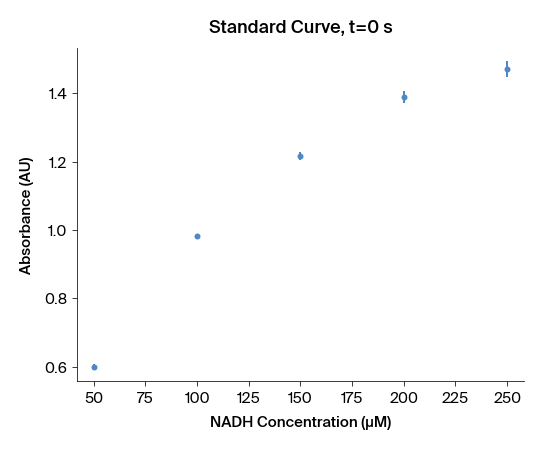

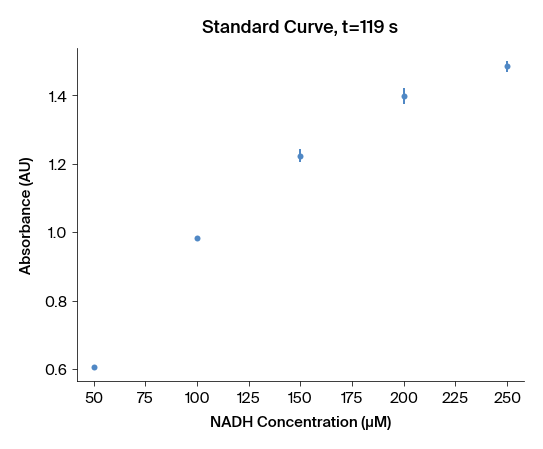

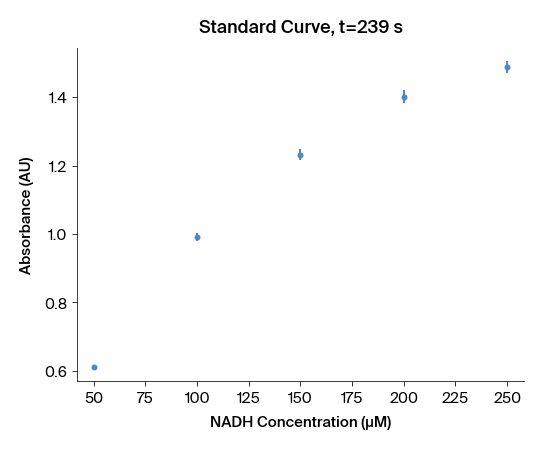

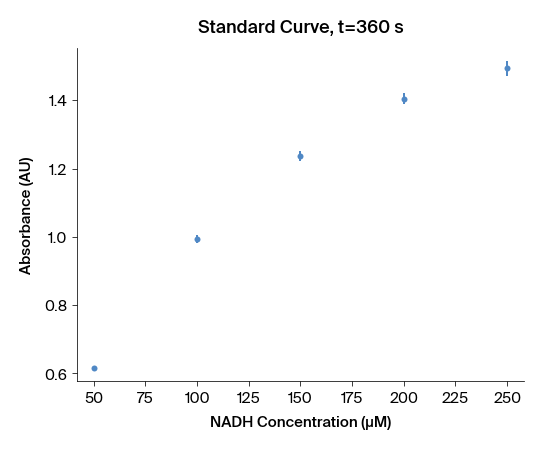

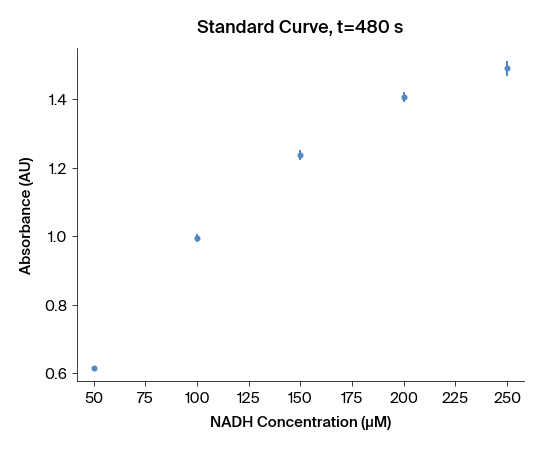

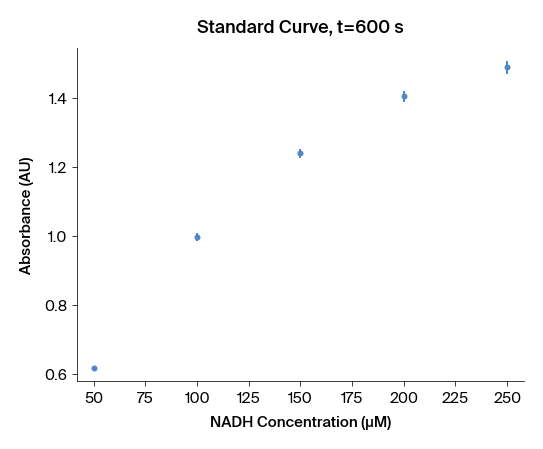

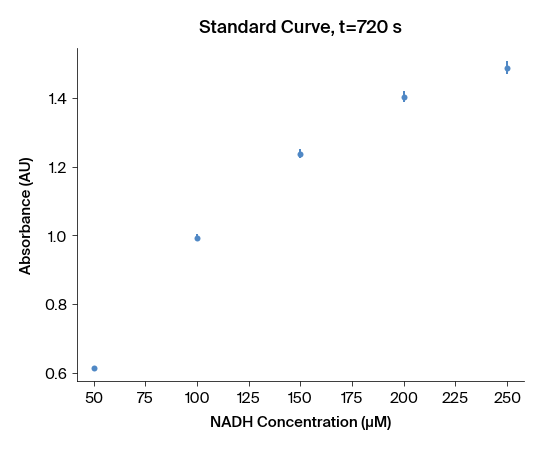

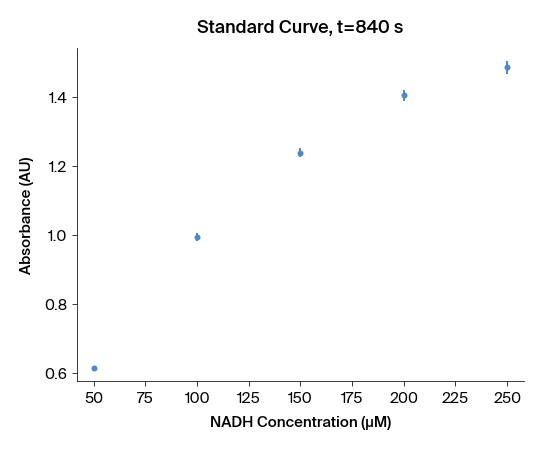

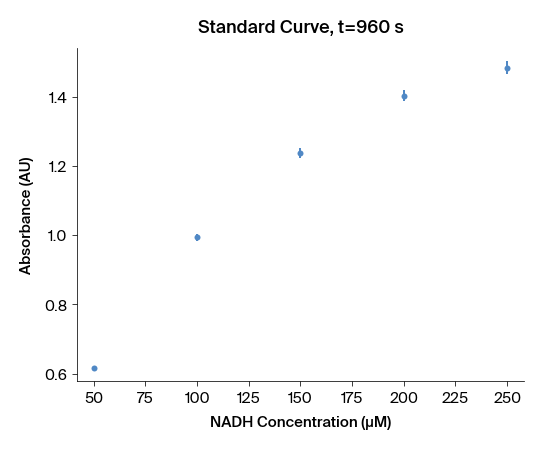

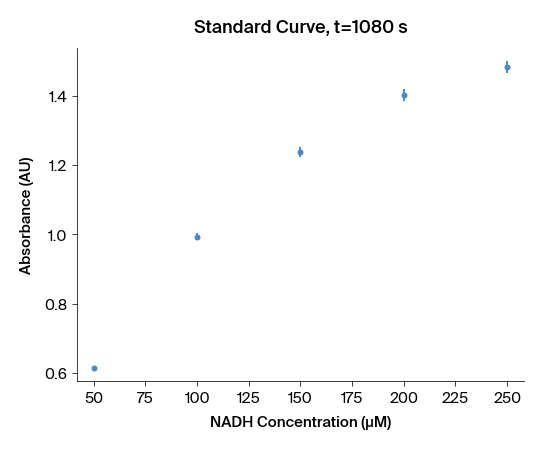

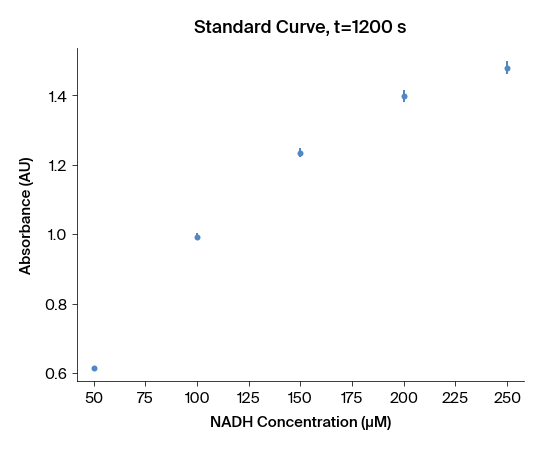

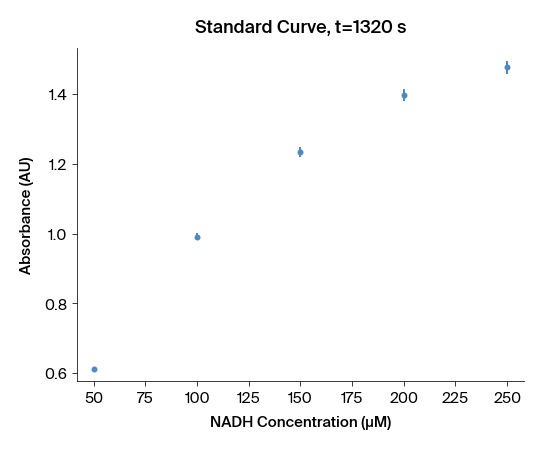

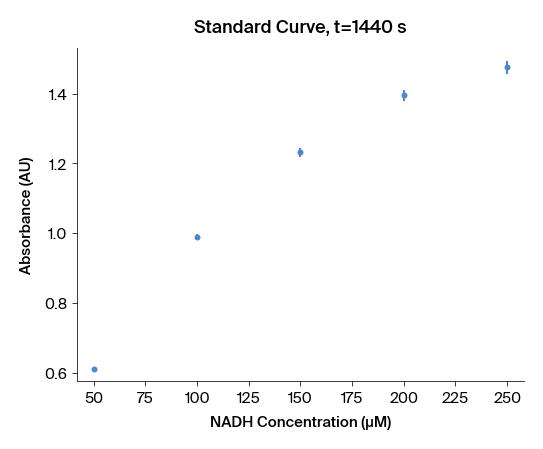

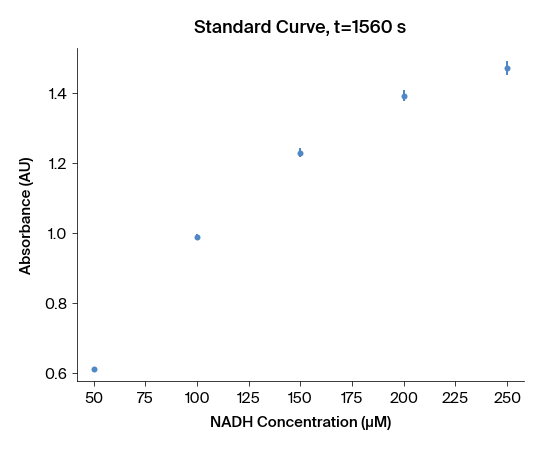

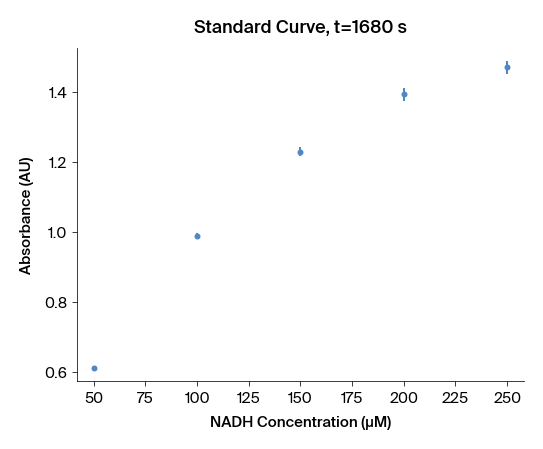

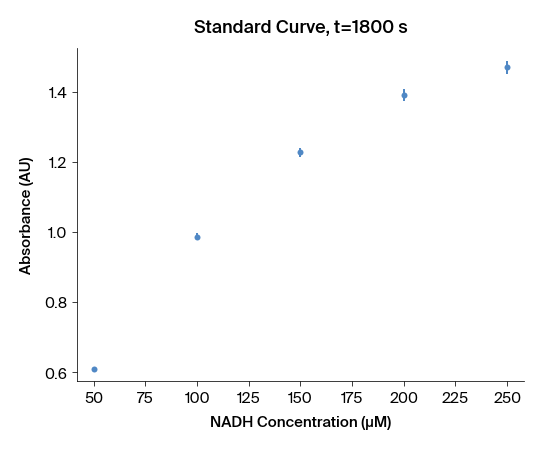

In [12]:
# Plot standard curves at each time point, which will be the basis for
# standard curve fitting and determining NADH concentrations in each well.

output_dir = "standard_curve_plots"
os.makedirs(output_dir, exist_ok=True)

time_points = sample_data_collapsed["Cycle (seconds)"].unique()

for time_point in time_points:
    time_point_data = sample_data_collapsed[sample_data_collapsed["Cycle (seconds)"] == time_point]

    means = time_point_data[standard_columns].mean()
    std_devs = time_point_data[standard_columns].std()

    x_values = [int(col) for col in standard_columns]
    y_values = means.values
    y_errors = std_devs.values

    apc.mpl.setup()
    plt.figure(figsize=(8, 6))
    plt.errorbar(
        x_values,
        y_values,
        yerr=y_errors,
        fmt="o",
        capsize=5,
        label=f"Time Point {time_point}",
    )

    # User can update labels and title as needed.
    plt.xlabel("NADH Concentration (µM)")
    plt.ylabel("Absorbance (AU)")
    plt.title(f"Standard Curve, t={round(time_point)} s")

    file_path = os.path.join(output_dir, f"standard_curve_timepoint_{round(time_point)}.png")
    plt.savefig(file_path, transparent=False)

    plt.show()

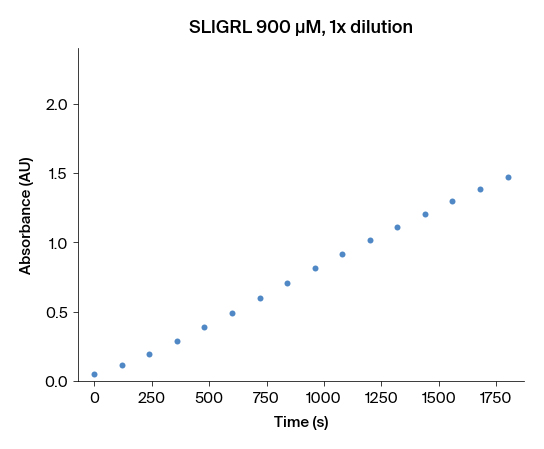

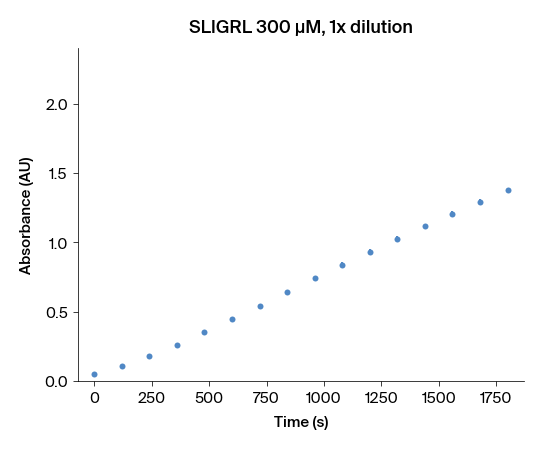

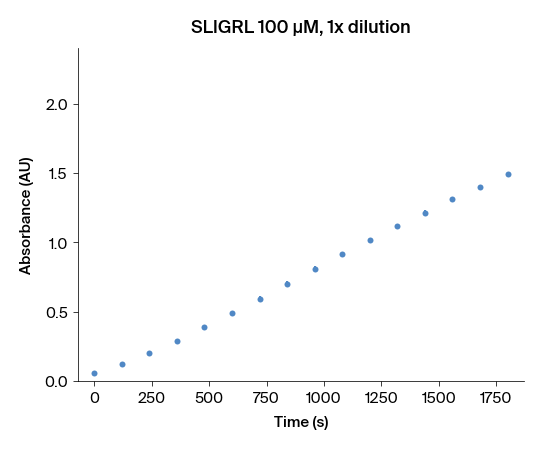

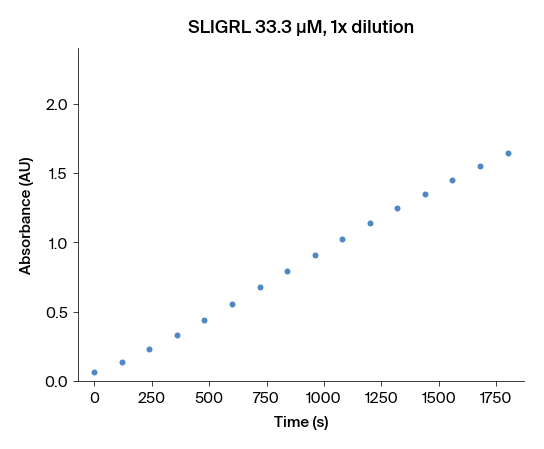

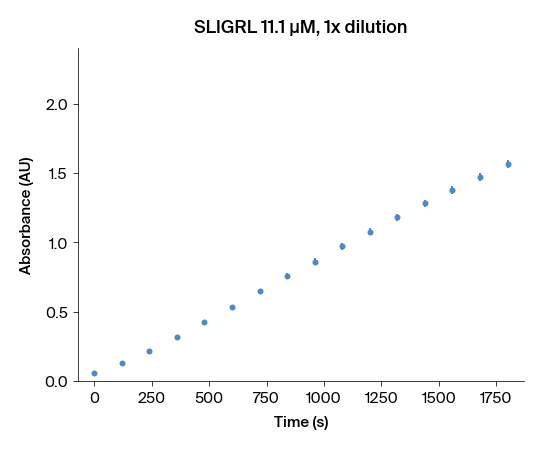

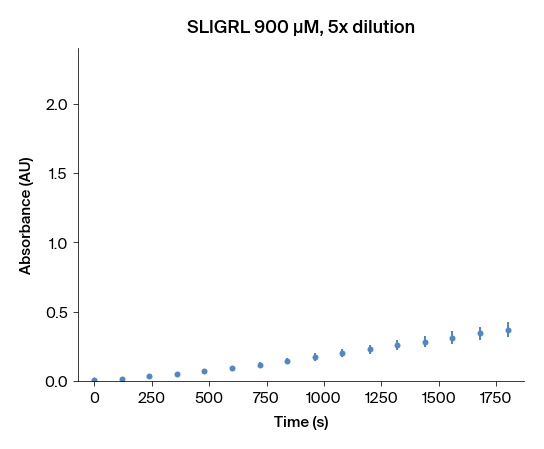

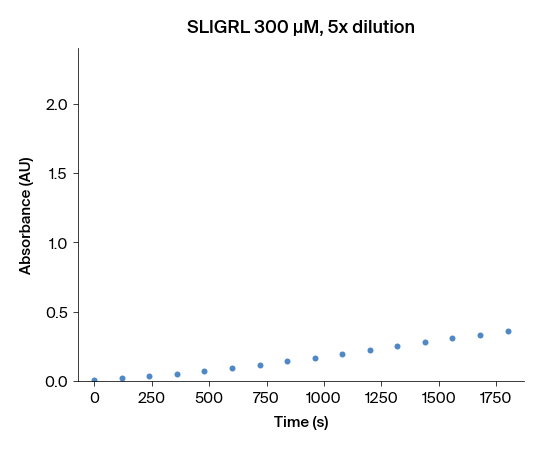

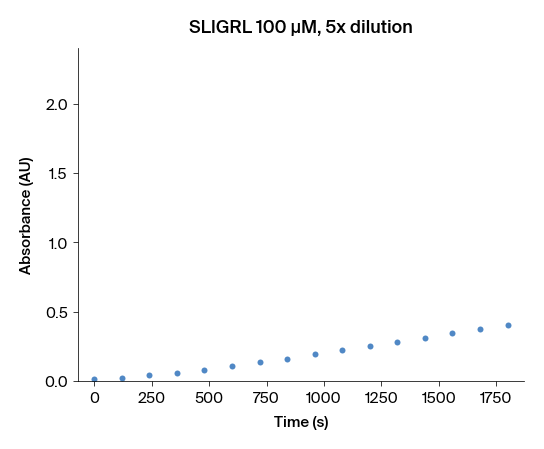

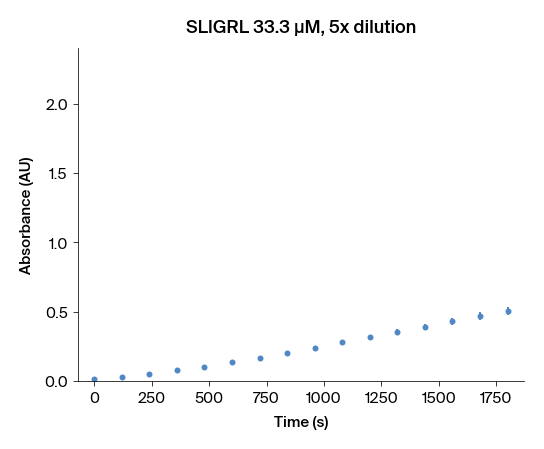

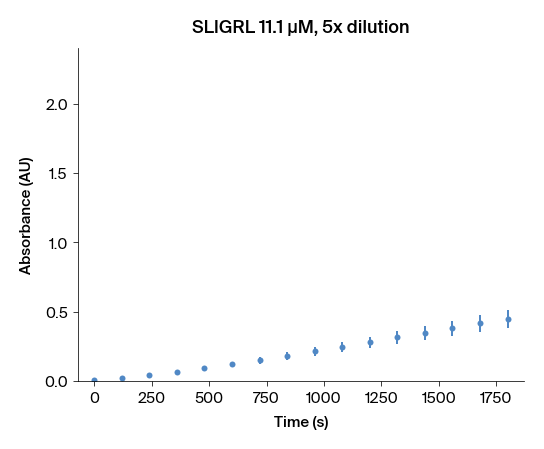

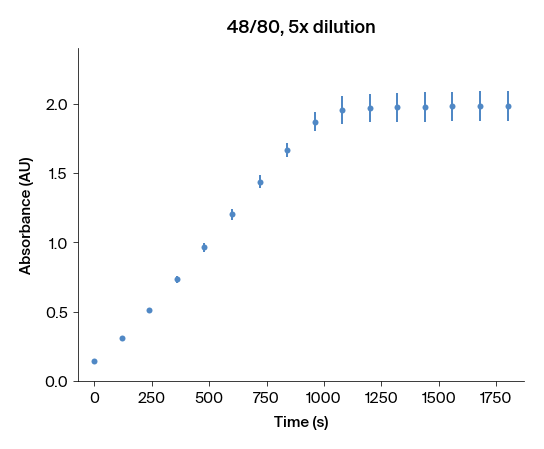

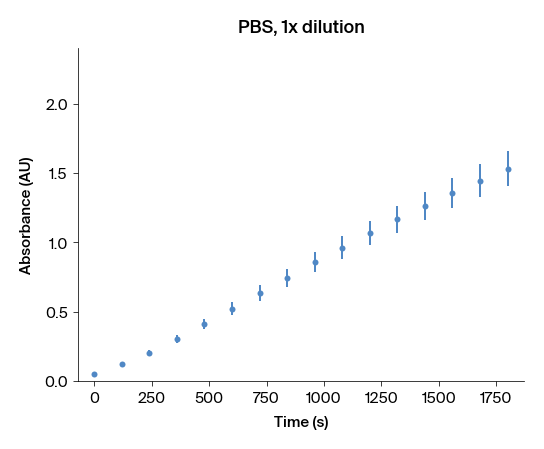

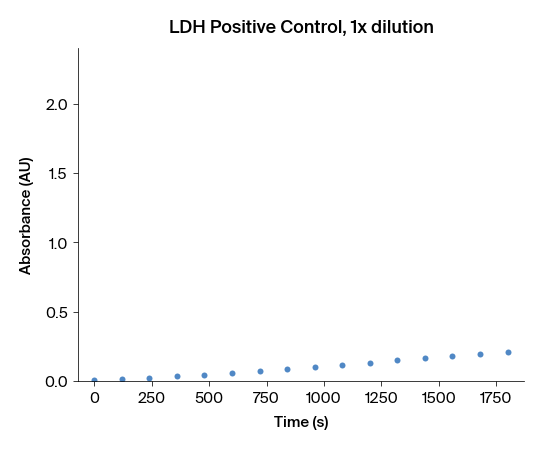

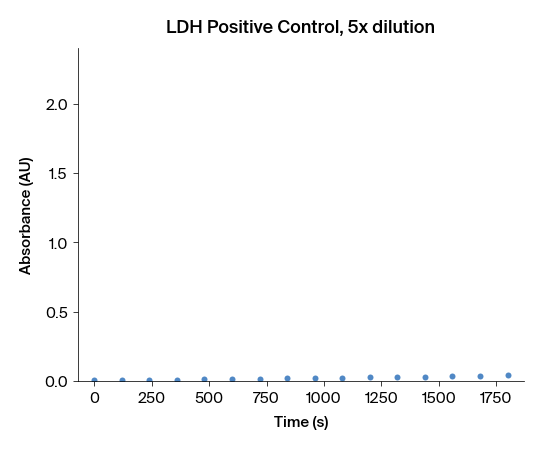

In [13]:
# Plot activity (signal vs. time) curves for each sample.
# Activity curves are used to select time points for enzyme activity quantification.

time_column = sample_data_collapsed.columns[0]
sample_columns = [
    col
    for col in sample_data_collapsed.columns
    if col not in standard_columns and col != time_column
]

output_dir = "activity_curves"
os.makedirs(output_dir, exist_ok=True)


def sanitize_filename(text):
    """
    Convert a string of text into a valid file name by replacing
    or removing problematic ' ', '/', and ',' characters.

    Args:
        text: A string, such as a sample name, to be sanitized.

    Returns:
        str: The sanitized string, which can serve as a filename.
    """
    sanitized = text.replace(" ", "_").replace("/", "_").replace(",", "")
    return sanitized


for col in sample_columns:
    grouped = sample_data_collapsed.groupby(time_column)[col]
    means = grouped.mean()
    std_devs = grouped.std()

    x_values = means.index
    y_values = means.values
    y_errors = std_devs.values

    plt.figure(figsize=(8, 6))
    plt.errorbar(x_values, y_values, yerr=y_errors, fmt="o", capsize=5, label=col)

    # User can update labels and title as needed.
    plt.xlabel("Time (s)")
    plt.ylabel("Absorbance (AU)")
    plt.ylim(0, 2.4)
    plt.title(f"{col}")

    col_sanitized = sanitize_filename(col)
    file_path = os.path.join(output_dir, f"activity_curve_{col_sanitized}.png")
    plt.savefig(file_path, transparent=False)

    plt.show()

In [14]:
# User must select time points t1 and t2 for analysis.
# Choose time points that fall in the linear range of the activity curves where possible.
t1 = 0  # s
t2 = 600  # s

if t1 is None or t2 is None:
    raise SystemExit("Please select time points for NADH and LDH quantification analysis")

In [15]:
# Curve fit will be performed on mean values of technical replicates,
# so a new dataframe containing the mean values will be generated.


def generate_mean_dataframe(collapsed_df, time_column):
    """
    Generate a mean dataframe with mean values for technical replicates at each time point.

    Args:
        collapsed_df: Dataframe containing labeled data with technical replicates.
        mean_df:
            A new dataframe with the same headers as collapsed_df,
            to be populated with mean values of technical replicates
        time_column: The name of the time column (i.e. 'Cycle (seconds)').

    Returns:
        pd.Dataframe:
            A populated dataframe containing the mean absorbance value
            for each sample at each time point.
    """
    mean_df = pd.DataFrame(columns=list(collapsed_df.columns))
    time_points = collapsed_df[time_column].unique()
    mean_df[time_column] = time_points

    for col in [c for c in collapsed_df.columns if c != time_column]:
        means = []

        for time_point in time_points:
            values = collapsed_df[collapsed_df[time_column] == time_point][col].dropna()
            mean_value = values.mean()
            means.append(mean_value)

        mean_df[col] = means

    return mean_df


sample_data_means = generate_mean_dataframe(sample_data_collapsed, time_column)
sample_data_means

,Cycle (seconds),"SLIGRL 900 µM, 1x dilution","SLIGRL 300 µM, 1x dilution","SLIGRL 100 µM, 1x dilution","SLIGRL 33.3 µM, 1x dilution","SLIGRL 11.1 µM, 1x dilution","SLIGRL 900 µM, 5x dilution","SLIGRL 300 µM, 5x dilution","SLIGRL 100 µM, 5x dilution","SLIGRL 33.3 µM, 5x dilution","SLIGRL 11.1 µM, 5x dilution","48/80, 5x dilution","PBS, 1x dilution",250,200,150,100,50,"LDH Positive Control, 1x dilution","LDH Positive Control, 5x dilution"
0,-0.0955,0.049500,0.048167,0.055167,0.062500,0.059167,0.006167,0.007500,0.010833,0.012833,0.010167,0.145167,0.050500,1.4715,1.3890,1.2165,0.9810,0.6000,0.005167,0.004833
1,118.9750,0.115000,0.107000,0.121000,0.138667,0.133333,0.017667,0.019000,0.023667,0.029000,0.025000,0.313000,0.120000,1.4855,1.3980,1.2245,0.9825,0.6065,0.012333,0.005333
2,238.9555,0.195500,0.178167,0.198833,0.229167,0.218500,0.033167,0.033833,0.040500,0.049833,0.044167,0.510500,0.205167,1.4885,1.4020,1.2320,0.9915,0.6100,0.021500,0.007167
3,359.8665,0.289833,0.261500,0.289833,0.333500,0.319500,0.052167,0.052500,0.061167,0.076500,0.067167,0.732500,0.305167,1.4935,1.4050,1.2380,0.9945,0.6155,0.032833,0.010167
4,479.7855,0.389500,0.350833,0.386500,0.443167,0.424500,0.072167,0.071500,0.082833,0.103833,0.091167,0.964500,0.411167,1.4910,1.4060,1.2375,0.9950,0.6145,0.043500,0.011167
5,599.9555,0.493833,0.445833,0.489833,0.558167,0.534833,0.095500,0.093833,0.107833,0.135167,0.119167,1.202500,0.522833,1.4890,1.4050,1.2390,0.9955,0.6150,0.058500,0.013833
6,719.8845,0.599500,0.542833,0.594833,0.675167,0.647500,0.118833,0.116167,0.133500,0.167500,0.148167,1.437500,0.634500,1.4875,1.4030,1.2375,0.9940,0.6140,0.069167,0.015500
7,839.8045,0.706500,0.642167,0.701167,0.792833,0.761167,0.144500,0.141500,0.161500,0.203167,0.179833,1.666167,0.745833,1.4850,1.4035,1.2380,0.9940,0.6140,0.083500,0.018167
8,959.7055,0.812500,0.741500,0.808833,0.911167,0.861500,0.173167,0.169500,0.193833,0.240833,0.213167,1.869833,0.856833,1.4855,1.4035,1.2380,0.9945,0.6150,0.100500,0.022167
9,1079.8755,0.915833,0.839500,0.913833,1.025500,0.971167,0.200833,0.196833,0.223500,0.278833,0.246833,1.955167,0.963167,1.4825,1.4015,1.2375,0.9940,0.6145,0.118167,0.025167


In [27]:
# This assay measures absorbance caused by NADH, a product of the LDH enzyme,
# so NADH concentrations at two time points are determined.
# Standard curve fits are determined at each of these time points.

time_column_list = sample_data_means[time_column].tolist()
time_column_list = [round(x) for x in time_column_list]

if t1 not in time_column_list or t2 not in time_column_list:
    raise SystemExit(
        "Time points not found. Please choose time points that are present in the dataset."
    )

else:
    # Try to find the index of t1 and t2
    t1loc = time_column_list.index(t1)
    t2loc = time_column_list.index(t2)

    # Check for NaN values in the corresponding rows
    row_t1 = sample_data_means.iloc[t1loc]
    row_t2 = sample_data_means.iloc[t2loc]

    if row_t1.isna().any() or row_t2.isna().any():
        print(
            """
            Time points successfully indexed for standard fitting.
            \nWarning: Data not available for all samples at these time points.
            """
        )
    else:
        print("Time points successfully indexed for standard fitting.")

Time points successfully indexed for standard fitting.


In [17]:
# Fit standard curve, t1

standard_ints = [int(x) for x in standard_columns]
x_values = np.array(standard_ints)
y_values_t1 = np.array([])

for col in standard_columns:
    value = sample_data_means.loc[t1loc, col]
    y_values_t1 = np.append(y_values_t1, value)


# Quadratic fit usually works best for absorbance data
def quadratic_model(x, a, b, c):
    return a * x**2 + b * x + c


quadratic_params_t1, _ = curve_fit(quadratic_model, x_values, y_values_t1)
quadratic_predictions_t1 = quadratic_model(x_values, *quadratic_params_t1)
quadratic_r2_t1 = r2_score(y_values_t1, quadratic_predictions_t1)

print("t1 fit successful")
print(f"a, b, c: {quadratic_params_t1}")
print(f"R^2: {quadratic_r2_t1:.4f}")

t1 fit successful
a, b, c: [-1.88571427e-05  9.95914282e-03  1.56300002e-01]
R^2: 0.9990


In [18]:
# Fit standard curve, t2

x_values = np.array(standard_ints)
y_values_t2 = np.array([])

for col in standard_columns:
    value = sample_data_means.loc[t2loc, col]
    y_values_t2 = np.append(y_values_t2, value)

quadratic_params_t2, _ = curve_fit(quadratic_model, x_values, y_values_t2)
quadratic_predictions_t2 = quadratic_model(x_values, *quadratic_params_t2)
quadratic_r2_t2 = r2_score(y_values_t2, quadratic_predictions_t2)

print("t2 fit successful")
print(f"a, b, c: {quadratic_params_t2}")
print(f"R^2: {quadratic_r2_t2:.4f}")

t2 fit successful
a, b, c: [-1.91571429e-05  1.00621429e-02  1.66199998e-01]
R^2: 0.9993


In [19]:
# To streamline the output data, NADH and LDH concentrations are calculated in a new dataframe.
# Relevant absorbance data will be extracted from sample_data_collapsed,
# then transformed to NADH concentrations using standard fit,
# then used to calculate LDH concentration in activity units.


def extract_data_by_time(df, time_value, time_column):
    """
    Extract data for a given time point and create a dictionary of absorbance readings
    for each sample at the given time point.

    Args:
        df: Dataframe containing labeled data with technical replicates.
        time_value: The time point for which the dictionary should be generated.
        time_column (str):
            The name of the column containing time values. Typically 'Cycle (seconds)'.

    Returns:
        dict:
            A dictionary where keys are sample names (as strings) and values are lists of
            absorbance readings (as floats).
    """
    filtered_df = df[round(df[time_column]) == time_value]
    data_dict = {col: filtered_df[col].dropna().tolist() for col in sample_columns}

    return data_dict


def populate_dataframe_with_dict(df, data_dict, key_column, value_column):
    """
    Populate the results dataframe with absorbance values at a given time point.

    Args:
        df: The results dataframe to populate.
        data_dict:
            A dictionary with sample names as keys and lists of
            absorbance values as values.
        key_column:
            The string header of the column in df that will contain sample names.
        value_column:
            The string header of the column in df that will contain
            absorbance values at the relevant time point.

    Returns:
        pd.DataFrame:
            The populated dataframe relating sample names to their
            absorbance values at the relevant time point.
    """
    for sample_name, values in data_dict.items():
        for value in values:
            mask = (df[key_column] == sample_name) & (df[value_column].isna())
            if mask.any():
                df.loc[mask.idxmax(), value_column] = value
            else:
                new_row = {key_column: sample_name, value_column: value}
                df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    return df


t1_dict = extract_data_by_time(sample_data_collapsed, t1, time_column)
t2_dict = extract_data_by_time(sample_data_collapsed, t2, time_column)

sample_column = "Sample"
t1_abs_column = "Abs, t = " + str(t1)
t2_abs_column = "Abs, t = " + str(t2)
conc_columns = [sample_column, t1_abs_column, t2_abs_column]
NADH_LDH_concs = pd.DataFrame(columns=conc_columns)

NADH_LDH_concs = populate_dataframe_with_dict(NADH_LDH_concs, t1_dict, sample_column, t1_abs_column)
NADH_LDH_concs = populate_dataframe_with_dict(NADH_LDH_concs, t2_dict, sample_column, t2_abs_column)
NADH_LDH_concs

/var/folders/f0/d5_1_5d11vl9ywq_z1j0nnk40000gn/T/ipykernel_16490/3770793334.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)


,Sample,"Abs, t = 0","Abs, t = 600"
0,"SLIGRL 900 µM, 1x dilution",0.0515,0.5035
1,"SLIGRL 900 µM, 1x dilution",0.0515,0.4935
2,"SLIGRL 900 µM, 1x dilution",0.0455,0.4845
3,"SLIGRL 300 µM, 1x dilution",0.0505,0.4605
4,"SLIGRL 300 µM, 1x dilution",0.0485,0.4415
5,"SLIGRL 300 µM, 1x dilution",0.0455,0.4355
6,"SLIGRL 100 µM, 1x dilution",0.0565,0.5055
7,"SLIGRL 100 µM, 1x dilution",0.0565,0.4815
8,"SLIGRL 100 µM, 1x dilution",0.0525,0.4825
9,"SLIGRL 33.3 µM, 1x dilution",0.0625,0.5695


In [20]:
# The curve fit parameters can be used to calculate the NADH concentrations
# at different time points, which can be used to determine enzyme activity.


def calculate_NADH_from_Abs(quadratic_params, df, abs_column):
    a, b, c = quadratic_params  # y = ax^2 + bx + c
    x_values = []
    y_values = df[abs_column]

    for y in y_values:
        adjusted_c = c - y

        discriminant = b**2 - 4 * a * adjusted_c

        if discriminant >= 0:
            root1 = (-b + np.sqrt(discriminant)) / (2 * a)
            root2 = (-b - np.sqrt(discriminant)) / (2 * a)

            # The correct NADH concentration should fall within the part of the curve
            # where absorbance increases with increasing NADH concentration.
            # For concave up fit, choose the non-negative (greater) root.
            # For concave down fit, choose the lesser positive root.
            if a > 0:
                root = max(root1, root2)
                x_values.append(root)
            else:
                root = min(root1, root2)
                x_values.append(root)

        else:
            # Handle cases where the discriminant is negative
            x_values.append(np.nan)

    x_values = np.array(x_values)
    return x_values


NADH_concs_t1 = calculate_NADH_from_Abs(quadratic_params_t1, NADH_LDH_concs, t1_abs_column)
NADH_concs_t2 = calculate_NADH_from_Abs(quadratic_params_t2, NADH_LDH_concs, t2_abs_column)

t1_NADH_column = "NADH, t = " + str(t1)
t2_NADH_column = "NADH, t = " + str(t2)

NADH_LDH_concs[t1_NADH_column] = NADH_concs_t1
NADH_LDH_concs[t2_NADH_column] = NADH_concs_t2
NADH_LDH_concs

,Sample,"Abs, t = 0","Abs, t = 600","NADH, t = 0","NADH, t = 600"
0,"SLIGRL 900 µM, 1x dilution",0.0515,0.5035,-10.321287,35.987391
1,"SLIGRL 900 µM, 1x dilution",0.0515,0.4935,-10.321287,34.838668
2,"SLIGRL 900 µM, 1x dilution",0.0455,0.4845,-10.900475,33.809748
3,"SLIGRL 300 µM, 1x dilution",0.0505,0.4605,-10.417903,31.088314
4,"SLIGRL 300 µM, 1x dilution",0.0485,0.4415,-10.611034,28.956324
5,"SLIGRL 300 µM, 1x dilution",0.0455,0.4355,-10.900475,28.287093
6,"SLIGRL 100 µM, 1x dilution",0.0565,0.5055,-9.837694,36.217835
7,"SLIGRL 100 µM, 1x dilution",0.0565,0.4815,-9.837694,33.467801
8,"SLIGRL 100 µM, 1x dilution",0.0525,0.4825,-10.224637,33.581727
9,"SLIGRL 33.3 µM, 1x dilution",0.0625,0.5695,-9.256254,43.720097


In [21]:
# Assay samples are sometimes diluted so that absorbance
# falls within range for accurate measurement.
# Extraction of dilution factors is necessary to calculate LDH enzyme concentrations.
# Sample names typically include the treatment (i.e. 5HT 3 µM)
# followed by the dilution factor (i.e. 1x dilution).
# A regular expression is used to identify this dilution factor.


def extract_dilution_factor(sample_name):
    """
    Extracts the dilution factor from a sample name string.

    Parameters:
        sample_name: The sample name to parse, as a string.

    Returns:
        int:
            The extracted dilution factor,
            or 1 if no dilution factor is found.
    """
    match = re.search(r"(\d+)x dilution", sample_name)
    if match:
        return int(match.group(1))
    else:
        return 1


dilution_factors = [extract_dilution_factor(sample) for sample in NADH_LDH_concs[sample_column]]
NADH_LDH_concs["dilution"] = dilution_factors
NADH_LDH_concs

,Sample,"Abs, t = 0","Abs, t = 600","NADH, t = 0","NADH, t = 600",dilution
0,"SLIGRL 900 µM, 1x dilution",0.0515,0.5035,-10.321287,35.987391,1
1,"SLIGRL 900 µM, 1x dilution",0.0515,0.4935,-10.321287,34.838668,1
2,"SLIGRL 900 µM, 1x dilution",0.0455,0.4845,-10.900475,33.809748,1
3,"SLIGRL 300 µM, 1x dilution",0.0505,0.4605,-10.417903,31.088314,1
4,"SLIGRL 300 µM, 1x dilution",0.0485,0.4415,-10.611034,28.956324,1
5,"SLIGRL 300 µM, 1x dilution",0.0455,0.4355,-10.900475,28.287093,1
6,"SLIGRL 100 µM, 1x dilution",0.0565,0.5055,-9.837694,36.217835,1
7,"SLIGRL 100 µM, 1x dilution",0.0565,0.4815,-9.837694,33.467801,1
8,"SLIGRL 100 µM, 1x dilution",0.0525,0.4825,-10.224637,33.581727,1
9,"SLIGRL 33.3 µM, 1x dilution",0.0625,0.5695,-9.256254,43.720097,1


In [22]:
# The change in NADH concentration over a known time interval can be used
# to calculate the LDH concentration in activity units.
# The extracted dilution factors will be used to determine the LDH
# concentration in the original supernatant sample.


def calculate_LDH_concs(df, t, V):
    LDH_concs = []

    for _index, row in df.iterrows():
        value_t2 = row[t2_NADH_column]
        value_t1 = row[t1_NADH_column]

        B = value_t2 - value_t1
        D = row["dilution"]

        if pd.isna(value_t2) or pd.isna(value_t1):
            LDH_concs.append(np.nan)

        else:
            conc = (B * D) / (t * V)
            if conc >= 0:
                LDH_concs.append(conc)

            else:
                LDH_concs.append(0)

    return LDH_concs


t = (t2 - t1) / 60  # Time interval in minutes

LDH_concs = calculate_LDH_concs(NADH_LDH_concs, t, V)
NADH_LDH_concs["LDH"] = LDH_concs
output_path = data_filename[:-4] + "_ldh_concs.csv"
NADH_LDH_concs.to_csv(output_path, index=False)
NADH_LDH_concs

,Sample,"Abs, t = 0","Abs, t = 600","NADH, t = 0","NADH, t = 600",dilution,LDH
0,"SLIGRL 900 µM, 1x dilution",0.0515,0.5035,-10.321287,35.987391,1,92.617356
1,"SLIGRL 900 µM, 1x dilution",0.0515,0.4935,-10.321287,34.838668,1,90.319910
2,"SLIGRL 900 µM, 1x dilution",0.0455,0.4845,-10.900475,33.809748,1,89.420446
3,"SLIGRL 300 µM, 1x dilution",0.0505,0.4605,-10.417903,31.088314,1,83.012435
4,"SLIGRL 300 µM, 1x dilution",0.0485,0.4415,-10.611034,28.956324,1,79.134715
5,"SLIGRL 300 µM, 1x dilution",0.0455,0.4355,-10.900475,28.287093,1,78.375137
6,"SLIGRL 100 µM, 1x dilution",0.0565,0.5055,-9.837694,36.217835,1,92.111059
7,"SLIGRL 100 µM, 1x dilution",0.0565,0.4815,-9.837694,33.467801,1,86.610991
8,"SLIGRL 100 µM, 1x dilution",0.0525,0.4825,-10.224637,33.581727,1,87.612727
9,"SLIGRL 33.3 µM, 1x dilution",0.0625,0.5695,-9.256254,43.720097,1,105.952702


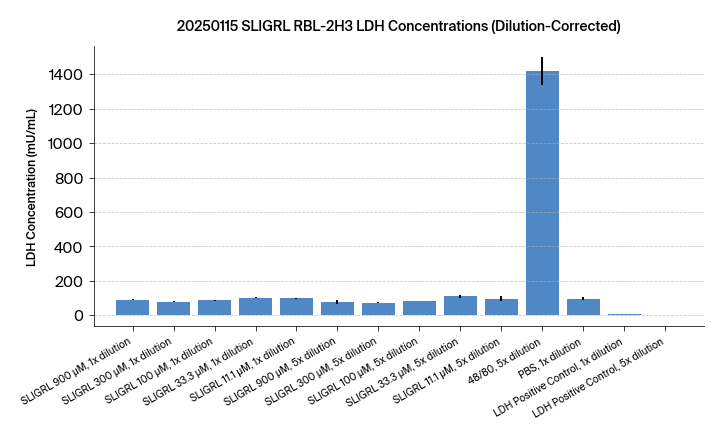

In [23]:
# Plot supernatant LDH concentrations for each sample.
# This plot visually represents the amount of cell death occurring
# in a given sample.
# Means and standard deviations of technical replicates are used to plot
# bars and error bars. Samples containing only NaN values are excluded.

grouped = (
    NADH_LDH_concs.groupby("Sample", sort=False)["LDH"]
    .agg(mean="mean", std="std", count="count")
    .reset_index()
)
grouped = grouped[grouped["count"] > 0]

samples = grouped["Sample"]
ldh_mean = grouped["mean"]
ldh_std = grouped["std"]

plt.figure(figsize=(10, 6))
plt.bar(samples, ldh_mean, yerr=ldh_std)

# User can update labels and title as needed.
plt.ylabel("LDH Concentration (mU/mL)", fontsize=12)
plt.title(experiment_id + " LDH Concentrations (Dilution-Corrected)", fontsize=14)

# Customize x-axis labels for better readability
plt.xticks(rotation=30, ha="right", fontsize=10)

plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig(
    data_filename[:-4] + "_LDH_concentrations.png",
    dpi=300,
    bbox_inches="tight",
    transparent=False,
)
plt.show()

In [24]:
# One-way ANOVA is the most appropriate statistical test for this experiment.

LDH_concs = NADH_LDH_concs[["Sample", "LDH"]]
LDH_concs = LDH_concs.dropna(subset=["LDH"])
grouped_data = [group["LDH"].values for _, group in LDH_concs.groupby("Sample")]

anova_result = f_oneway(*grouped_data)
print(f"ANOVA result: F-value = {anova_result.statistic}, p-value = {anova_result.pvalue}")

ANOVA result: F-value = 751.8007474990211, p-value = 5.117566641404848e-32


In [25]:
# Tukey's HSD test is the most appropriate statistical test for post-hoc analysis.

tukey_result = pairwise_tukeyhsd(endog=LDH_concs["LDH"], groups=LDH_concs["Sample"], alpha=0.05)
print(tukey_result)

tukey_df = pd.DataFrame(
    data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0]
)
tukey_df.to_csv(data_filename[:-4] + "_tukey_hsd_results.csv", index=False)

                               Multiple Comparison of Means - Tukey HSD, FWER=0.05                                
              group1                            group2               meandiff  p-adj    lower      upper    reject
------------------------------------------------------------------------------------------------------------------
               48/80, 5x dilution LDH Positive Control, 1x dilution -1411.0379    0.0 -1479.0232 -1343.0526   True
               48/80, 5x dilution LDH Positive Control, 5x dilution -1418.7346    0.0 -1486.7199 -1350.7494   True
               48/80, 5x dilution                  PBS, 1x dilution -1322.2055    0.0 -1390.1908 -1254.2202   True
               48/80, 5x dilution        SLIGRL 100 µM, 1x dilution -1330.7982    0.0 -1398.7834 -1262.8129   True
               48/80, 5x dilution        SLIGRL 100 µM, 5x dilution -1334.7231    0.0 -1402.7084 -1266.7379   True
               48/80, 5x dilution       SLIGRL 11.1 µM, 1x dilution -1321.1586  

In [26]:
import sys

loaded_modules = {
    name: mod.__version__ for name, mod in sys.modules.items() if hasattr(mod, "__version__")
}
print(loaded_modules)

{'re': '2.2.1', 'ipaddress': '1.0', 'ipykernel._version': '6.29.4', 'json': '2.0.9', 'jupyter_client._version': '8.6.2', 'platform': '1.0.8', 'zmq.sugar.version': '26.0.3', 'zmq.sugar': '26.0.3', 'zmq': '26.0.3', 'logging': '0.5.1.2', 'traitlets._version': '5.14.3', 'traitlets': '5.14.3', 'jupyter_core.version': '5.7.2', 'jupyter_core': '5.7.2', 'zlib': '1.0', '_curses': b'2.2', 'socketserver': '0.4', 'argparse': '1.1', 'dateutil._version': '2.9.0.post0', 'dateutil': '2.9.0.post0', 'six': '1.16.0', '_decimal': '1.70', 'decimal': '1.70', 'platformdirs.version': '4.2.2', 'platformdirs': '4.2.2', '_csv': '1.0', 'csv': '1.0', 'jupyter_client': '8.6.2', 'ipykernel': '6.29.4', 'IPython.core.release': '8.26.0', 'executing.version': '2.0.1', 'executing': '2.0.1', 'pure_eval.version': '0.2.2', 'pure_eval': '0.2.2', 'stack_data.version': '0.6.3', 'stack_data': '0.6.3', 'pygments': '2.18.0', 'decorator': '5.1.1', 'wcwidth': '0.2.13', 'prompt_toolkit': '3.0.47', 'parso': '0.8.4', 'jedi': '0.19.1',

/var/folders/f0/d5_1_5d11vl9ywq_z1j0nnk40000gn/T/ipykernel_16490/3849240522.py:4: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.__version__.
  name: mod.__version__ for name, mod in sys.modules.items() if hasattr(mod, "__version__")
